# Importing Library :

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb

# Loading the datasets :

In [6]:

# Reading training data for the emoticon-based task
train_emoticon_data = pd.read_csv("/content/train_emoticon.csv")
emoticon_train_inputs = train_emoticon_data['input_emoticon'].tolist()
emoticon_train_labels = train_emoticon_data['label'].tolist()

# Reading validation data for the emoticon-based task
validation_emoticon_data = pd.read_csv("/content/valid_emoticon.csv")
emoticon_validation_inputs = validation_emoticon_data['input_emoticon'].tolist()
emoticon_validation_labels = validation_emoticon_data['label'].tolist()

# Reading training data for the text sequence task
train_text_data = pd.read_csv("/content/train_text_seq.csv")
text_train_inputs = train_text_data['input_str'].tolist()
text_train_labels = train_text_data['label'].tolist()

# Reading validation data for the text sequence task
validation_text_data = pd.read_csv("/content/valid_text_seq.csv")
text_validation_inputs = validation_text_data['input_str'].tolist()
text_validation_labels = validation_text_data['label'].tolist()

# Loading pre-processed feature dataset for training
feature_train_data = np.load("/content/train_feature.npz", allow_pickle=True)
features_train_inputs = feature_train_data['features']
features_train_labels = feature_train_data['label']

# Loading pre-processed feature dataset for validation
feature_validation_data = np.load("/content/valid_feature.npz", allow_pickle=True)
features_validation_inputs = feature_validation_data['features']
features_validation_labels = feature_validation_data['label']


# Dataset Details :

In [7]:
# Display dataset sizes
print("Training dataset sizes:")
print(f"Emoticon inputs: {len(emoticon_train_inputs)}, Emoticon labels: {len(emoticon_train_labels)}")
print(f"Text sequence inputs: {len(text_train_inputs)}, Text sequence labels: {len(text_train_labels)}")
print(f"Feature matrix shape: {features_train_inputs.shape}, Feature labels shape: {features_train_labels.shape}")

print("\nValidation dataset sizes:")
print(f"Emoticon inputs: {len(emoticon_validation_inputs)}")
print(f"Text sequence inputs: {len(text_validation_inputs)}")
print(f"Feature matrix shape: {features_validation_inputs.shape}")

Training dataset sizes:
Emoticon inputs: 7080, Emoticon labels: 7080
Text sequence inputs: 7080, Text sequence labels: 7080
Feature matrix shape: (7080, 13, 768), Feature labels shape: (7080,)

Validation dataset sizes:
Emoticon inputs: 489
Text sequence inputs: 489
Feature matrix shape: (489, 13, 768)


# Data processing :

In [8]:

# Encoding categorical data for emoticons and text sequences
encoder = OneHotEncoder(handle_unknown='ignore')

# Transform emoticon training and validation sets
encoded_emoticon_train = encoder.fit_transform(np.array(emoticon_train_inputs).reshape(-1, 1)).toarray()
encoded_emoticon_validation = encoder.transform(np.array(emoticon_validation_inputs).reshape(-1, 1)).toarray()

# Transform text sequence training and validation sets
encoded_text_train = encoder.fit_transform(np.array(text_train_inputs).reshape(-1, 1)).toarray()
encoded_text_validation = encoder.transform(np.array(text_validation_inputs).reshape(-1, 1)).toarray()

# Normalize the feature dataset using standard scaling
scaler = StandardScaler()

# Scale training features
scaled_features_train = scaler.fit_transform(features_train_inputs.reshape(features_train_inputs.shape[0], -1))

# Scale validation features
scaled_features_validation = scaler.transform(features_validation_inputs.reshape(features_validation_inputs.shape[0], -1))

# Combine all processed training data into a single matrix
train_data_combined = np.hstack((encoded_emoticon_train, encoded_text_train, scaled_features_train))
train_labels_combined = np.array(emoticon_train_labels)  # Assuming all datasets share the same labels

# Combine all processed validation data into a single matrix
validation_data_combined = np.hstack((encoded_emoticon_validation, encoded_text_validation, scaled_features_validation))
validation_labels_combined = np.array(emoticon_validation_labels)


# Combined data details :

In [9]:
train_data_combined

array([[ 0.        ,  0.        ,  0.        , ..., -0.28983393,
        -0.24607322,  1.4753989 ],
       [ 0.        ,  0.        ,  0.        , ...,  1.64987433,
        -0.70957798,  0.2628164 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.54141045,
        -0.55918396,  0.31773353],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.7908113 ,
         1.15807533, -0.98032582],
       [ 0.        ,  0.        ,  0.        , ...,  0.64058501,
        -0.87167823, -0.86577237],
       [ 0.        ,  0.        ,  0.        , ..., -0.77007782,
         0.22331148, -1.24868262]])

# Data Fraction Selection :

In [10]:

# Define the fractions of the training dataset to be used, ranging from 10% to 100%
data_fractions = np.linspace(0.1, 1.0, 10)

# Lists to store training and validation accuracies
training_accuracies = []
validation_accuracies = []


# On overall Dataset:



# Using Random Forest Classifer:

In [11]:

# Loop over different fractions of the training dataset
for fraction in data_fractions:
    # Select a subset of the training data
    subset_size = int(fraction * train_data_combined.shape[0])
    train_subset_X = train_data_combined[:subset_size]
    train_subset_Y = train_labels_combined[:subset_size]

    # Initialize the Random Forest model with stronger regularization
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=8,             # Reduced max depth
        min_samples_split=10,    # Increased min samples split
        min_samples_leaf=5,      # Increased min samples per leaf
        max_features='sqrt',     # Limit the number of features considered for each split
        bootstrap=False,         # Use all data for each tree (no bootstrap sampling)
        random_state=42
    )
    rf_model.fit(train_subset_X, train_subset_Y)

    # Evaluate the model on the training subset
    train_subset_predictions = rf_model.predict(train_subset_X)
    train_subset_accuracy = accuracy_score(train_subset_Y, train_subset_predictions)

    # Evaluate the model on the full validation set
    validation_predictions = rf_model.predict(validation_data_combined)
    validation_accuracy = accuracy_score(validation_labels_combined, validation_predictions)

    # Store the results for plotting
    training_accuracies.append(train_subset_accuracy)
    validation_accuracies.append(validation_accuracy)

    print(f"Training with {fraction * 100:.1f}% of data - "
          f"Train Accuracy: {train_subset_accuracy:.4f}, "
          f"Validation Accuracy: {validation_accuracy:.4f}")


Training with 10.0% of data - Train Accuracy: 1.0000, Validation Accuracy: 0.9489
Training with 20.0% of data - Train Accuracy: 1.0000, Validation Accuracy: 0.9591
Training with 30.0% of data - Train Accuracy: 0.9995, Validation Accuracy: 0.9796
Training with 40.0% of data - Train Accuracy: 0.9996, Validation Accuracy: 0.9714
Training with 50.0% of data - Train Accuracy: 0.9992, Validation Accuracy: 0.9693
Training with 60.0% of data - Train Accuracy: 0.9991, Validation Accuracy: 0.9775
Training with 70.0% of data - Train Accuracy: 0.9992, Validation Accuracy: 0.9816
Training with 80.0% of data - Train Accuracy: 0.9993, Validation Accuracy: 0.9836
Training with 90.0% of data - Train Accuracy: 0.9992, Validation Accuracy: 0.9796
Training with 100.0% of data - Train Accuracy: 0.9993, Validation Accuracy: 0.9836


# Plot the results: Training and Validation Accuracy vs. Percentage of Training Data

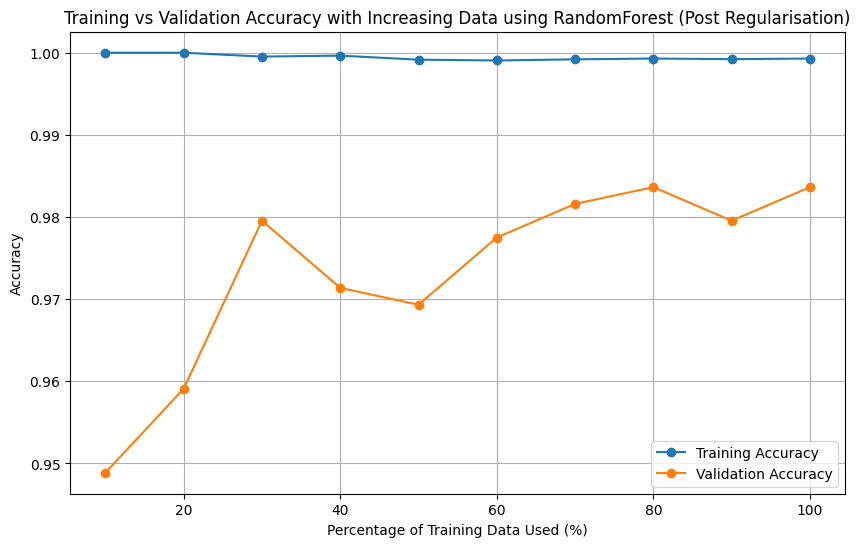

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(data_fractions * 100, training_accuracies, label='Training Accuracy', marker='o')
plt.plot(data_fractions * 100, validation_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy with Increasing Data using RandomForest (Post Regularisation)')
plt.legend()
plt.grid(True)
plt.show()



# On Task Part:

## Task 1 part 1:(emoticon)

  emoticon_1 emoticon_2 emoticon_3  label
0          😻          🙠          😒      0
1          😪          🚅          😹      0
2          🚡          🙲          🛑      0
3          🙐          🙪          🛆      1
4          🚟          🙋          😹      1
Best hyperparameters: {'alpha': 0.01, 'eta0': 0.1, 'learning_rate': 'invscaling', 'loss': 'perceptron', 'penalty': 'l2'}
Training on 10.0% of data - Train Accuracy: 0.9972, Validation Accuracy: 0.7791, Number of Parameters: 503
Training on 20.0% of data - Train Accuracy: 0.9838, Validation Accuracy: 0.8323, Number of Parameters: 503
Training on 30.0% of data - Train Accuracy: 0.9896, Validation Accuracy: 0.8630, Number of Parameters: 503
Training on 40.0% of data - Train Accuracy: 0.9880, Validation Accuracy: 0.9264, Number of Parameters: 503
Training on 50.0% of data - Train Accuracy: 0.9927, Validation Accuracy: 0.9427, Number of Parameters: 503
Training on 60.0% of data - Train Accuracy: 0.9918, Validation Accuracy: 0.9489, Number of P

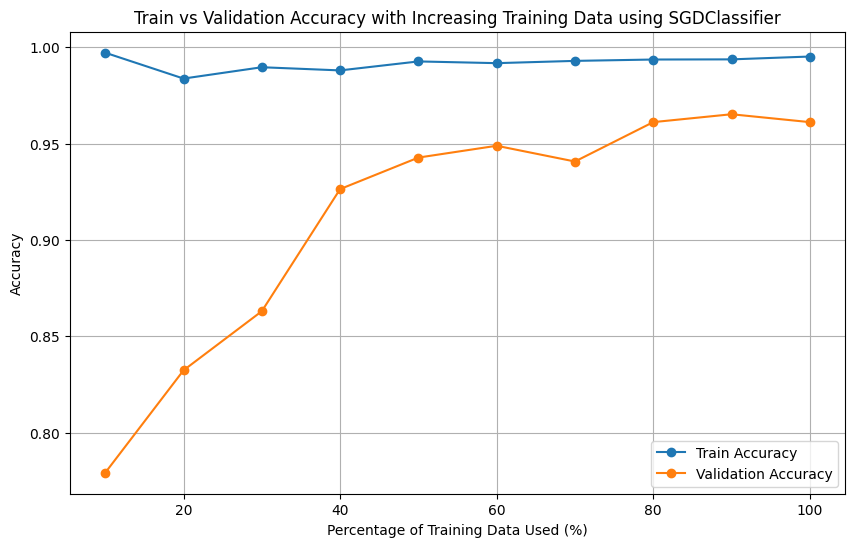

In [13]:
training_df = pd.read_csv('train_emoticon.csv')
validation_df = pd.read_csv('valid_emoticon.csv')

# Function to extract emojis from each row
def extract_emojis(row):
    return list(row)

# Creating a set of emojis for each row
training_df['emoji_list'] = training_df['input_emoticon'].apply(extract_emojis)

# Finding common emojis across all rows
common_emojis = set(training_df['emoji_list'][0])
for emojis in training_df['emoji_list']:
    common_emojis.intersection_update(emojis)

# Removing common emojis and non-unique emojis from each row
def remove_common_and_duplicates(emojis, common):
    unique_emojis = []
    seen = set()
    for emoji in emojis:
        if emoji not in common and emoji not in seen:
            unique_emojis.append(emoji)
            seen.add(emoji)
    return ''.join(unique_emojis)

# Applying the function to remove common emojis and duplicates
training_df['non_repeating_emojis'] = training_df['emoji_list'].apply(lambda x: remove_common_and_duplicates(x, common_emojis))

# Storing only the non-repeating emojis and the label in the new CSV
training_df[['non_repeating_emojis', 'label']].to_csv('updated_training_data.csv', index=False)


# Similary for validation data

# Creating a set of emojis for each row
validation_df['emoji_list'] = validation_df['input_emoticon'].apply(extract_emojis)

# Finding common emojis across all rows
common_emojis2 = set(validation_df['emoji_list'][0])
for emojis in validation_df['emoji_list']:
    common_emojis2.intersection_update(emojis)

# Applying the function to remove common emojis and duplicates
validation_df['non_repeating_emojis'] = validation_df['emoji_list'].apply(lambda x: remove_common_and_duplicates(x, common_emojis2))

# Storing only the non-repeating emojis and the label in the new CSV
validation_df[['non_repeating_emojis', 'label']].to_csv('updated_validation_data.csv', index=False)

new_training_data = 'updated_training_data.csv'
new_validation_data = 'updated_validation_data.csv'

# Reading the datasets
train_df = pd.read_csv(new_training_data)
valid_df = pd.read_csv(new_validation_data)

# Spliting the 'non_repeating_emojis' column into separate columns for each emoji
train_df_split = train_df['non_repeating_emojis'].apply(lambda x: pd.Series(list(x)))
valid_df_split = valid_df['non_repeating_emojis'].apply(lambda x: pd.Series(list(x)))

num_emojis = 3  # number of unique emojis in the each training example row
train_df_split.columns = [f'emoticon_{i}' for i in range(1, num_emojis + 1)]
valid_df_split.columns = [f'emoticon_{i}' for i in range(1, num_emojis + 1)]

# Combining the split columns with the original 'label' column
train_df_final = pd.concat([train_df_split, train_df['label']], axis=1)
valid_df_final = pd.concat([valid_df_split, valid_df['label']], axis=1)

# Showing the first few rows of the training set after splitting
print(train_df_final.head())
# Defining the fractions of the training data to use (from 10% to 100%)
fractions = np.linspace(0.1, 1.0, 10)  # Correctly using 'fractions' from the SGDClassifier section

# Initialize lists to store accuracies and parameter counts
train_accuracies = []
valid_accuracies = []
parameter_counts = []

# Initializing the OneHotEncoder and fit it on the combined training and validation data
encoder = OneHotEncoder()
combined_data = pd.concat([train_df_final, valid_df_final]).drop(columns=['label'])
encoder.fit(combined_data)

# Defining hyperparameter grid for GridSearchCV
param_grid = {
    'loss': ['modified_huber', 'perceptron', 'hinge', 'log_loss'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-2, 1e-1, 1],  # Regularization strengths
    'learning_rate': ['constant', 'optimal', 'invscaling'],
    'eta0': [0.01, 0.1, 1]  # Initial learning rates
}

# Initializing GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(SGDClassifier(max_iter=1000), param_grid, cv=5, scoring='accuracy')

# Encode the full training data
X_train_full_encoded = encoder.transform(train_df_final.drop(columns=['label']))
y_train_full = train_df_final['label']

# Fitting the model on the entire training set to find the best hyperparameters
grid_search.fit(X_train_full_encoded, y_train_full)

# Extracting the best hyperparameters
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

for fraction in fractions:
    # Subsample the training data
    train_sample = train_df_final.sample(frac=fraction, random_state=42)

    # Separate features and labels for the subsample
    X_train_sample = train_sample.drop(columns=['label'])
    y_train_sample = train_sample['label']

    # Encode the subsampled training data using the pre-fitted encoder
    X_train_encoded = encoder.transform(X_train_sample)

    # Initialize and train the SGDClassifier with the best hyperparameters
    model = SGDClassifier(**best_params, max_iter=1000, tol=1e-3)
    model.fit(X_train_encoded, y_train_sample)

    # Predict on the training set and compute training accuracy
    y_train_pred = model.predict(X_train_encoded)
    train_accuracy = accuracy_score(y_train_sample, y_train_pred)

    # Encode and predict on the validation set
    X_valid_encoded = encoder.transform(valid_df_final.drop(columns=['label']))
    y_valid_pred = model.predict(X_valid_encoded)
    valid_accuracy = accuracy_score(valid_df_final['label'], y_valid_pred)

    # Calculating the number of parameters (features + intercepts)
    num_parameters = model.coef_.shape[1] + model.coef_.shape[0]

    # Storing accuracies and parameter counts
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)
    parameter_counts.append(num_parameters)

    print(f"Training on {fraction * 100:.1f}% of data - "
          f"Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Accuracy: {valid_accuracy:.4f}, "
          f"Number of Parameters: {num_parameters}")

# Plotting train and validation accuracies against data fractions
plt.figure(figsize=(10, 6))

# Use 'fractions * 100' to plot against both accuracies lists
plt.plot(fractions * 100, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(fractions * 100, valid_accuracies, label='Validation Accuracy', marker='o')

plt.xlabel('Percentage of Training Data Used (%)')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy with Increasing Training Data using SGDClassifier')
plt.legend()
plt.grid(True)
plt.show()


## Task 1 Part 2:(Features)

Training with 10% of the data:
Validation Accuracy: 0.94
Confusion Matrix:
 [[242  10]
 [ 18 219]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95       252
           1       0.96      0.92      0.94       237

    accuracy                           0.94       489
   macro avg       0.94      0.94      0.94       489
weighted avg       0.94      0.94      0.94       489

-----

Training with 20% of the data:
Validation Accuracy: 0.96
Confusion Matrix:
 [[240  12]
 [  9 228]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96       252
           1       0.95      0.96      0.96       237

    accuracy                           0.96       489
   macro avg       0.96      0.96      0.96       489
weighted avg       0.96      0.96      0.96       489

-----

Training with 30% of the data:
Validation Accuracy: 0.98
Confusion Matrix:
 [[243   9]

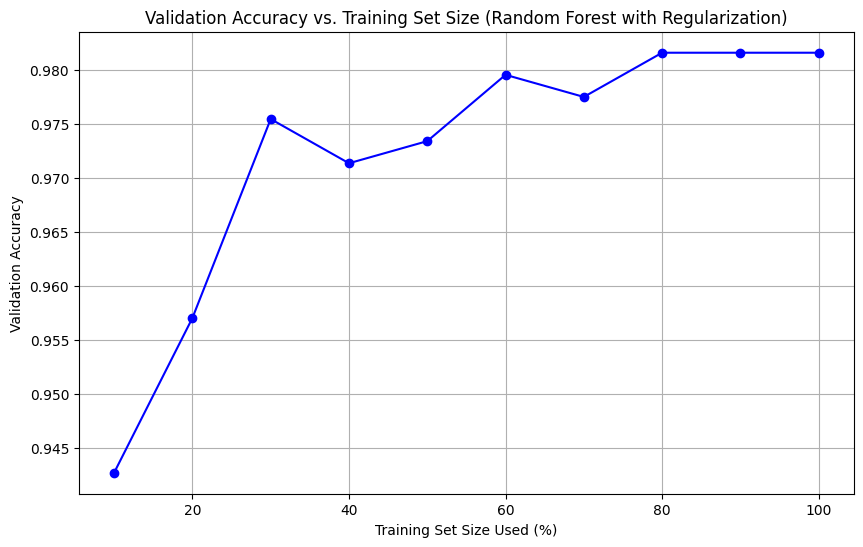

In [14]:
# Load training feature data
training_data = np.load("/content/train_feature.npz", allow_pickle=True)
train_features = training_data['features']
train_labels = training_data['label']

# Load validation feature data
validation_data = np.load("/content/valid_feature.npz", allow_pickle=True)
valid_features = validation_data['features']
valid_labels = validation_data['label']


# Ensure labels are in integer format
train_labels = train_labels.astype(int)  # Assumes classes are 0 and 1
valid_labels = valid_labels.astype(int)  # Assumes classes are 0 and 1

# Flatten the feature arrays from (samples, 13, 786) to (samples, 13 * 786)
num_train_samples = train_features.shape[0]
num_valid_samples = valid_features.shape[0]

flat_train_features = train_features.reshape(num_train_samples, -1)
flat_valid_features = valid_features.reshape(num_valid_samples, -1)

# Normalize the feature data
scaler = StandardScaler()
flat_train_features = scaler.fit_transform(flat_train_features)
flat_valid_features = scaler.transform(flat_valid_features)
# Define the fractions of the training dataset to be used, ranging from 10% to 100%
data_fractions2 = np.linspace(0.1, 1.0, 10)

# Initialize a list to store the accuracies for each fraction of the training data
model_accuracies = []

# Train and evaluate the model for each fraction of the training data
for fraction in data_fractions2:
    # Determine the size of the subset
    subset_size = int(num_train_samples * fraction)
    subset_train_features = flat_train_features[:subset_size]
    subset_train_labels = train_labels[:subset_size]

    # Initialize and train the Random Forest model with regularization parameters
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,              # Maximum depth of each tree
        min_samples_split=5,       # Minimum samples required to split an internal node
        min_samples_leaf=2,        # Minimum number of samples required to be at a leaf node
        random_state=42
    )

    rf_model.fit(subset_train_features, subset_train_labels)

    # Predict on the validation data
    valid_predictions = rf_model.predict(flat_valid_features)

    # Measure the accuracy on the validation set
    accuracy = accuracy_score(valid_labels, valid_predictions)
    model_accuracies.append(accuracy)

    # Output metrics for each training fraction
    print(f"Training with {int(fraction * 100)}% of the data:")
    print(f"Validation Accuracy: {accuracy:.2f}")
    print("Confusion Matrix:\n", confusion_matrix(valid_labels, valid_predictions))
    print("Classification Report:\n", classification_report(valid_labels, valid_predictions))
    print("-----\n")

# Visualize the accuracy versus training data fraction
plt.figure(figsize=(10, 6))
plt.plot([int(f * 100) for f in data_fractions2], model_accuracies, marker='o', color='blue')
plt.title("Validation Accuracy vs. Training Set Size (Random Forest with Regularization)")
plt.xlabel("Training Set Size Used (%)")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()


## Task 1 Part 3:(Text Sequence)

Training with 10.0% of data - Train Accuracy: 1.0000, Validation Accuracy: 0.7072
Training with 20.0% of data - Train Accuracy: 1.0000, Validation Accuracy: 0.7918
Training with 30.0% of data - Train Accuracy: 1.0000, Validation Accuracy: 0.8026
Training with 40.0% of data - Train Accuracy: 0.9996, Validation Accuracy: 0.8395
Training with 50.0% of data - Train Accuracy: 0.9991, Validation Accuracy: 0.8460
Training with 60.0% of data - Train Accuracy: 0.9990, Validation Accuracy: 0.8525
Training with 70.0% of data - Train Accuracy: 0.9989, Validation Accuracy: 0.8590
Training with 80.0% of data - Train Accuracy: 0.9974, Validation Accuracy: 0.8764
Training with 90.0% of data - Train Accuracy: 0.9958, Validation Accuracy: 0.8720
Training with 100.0% of data - Train Accuracy: 0.9952, Validation Accuracy: 0.8720


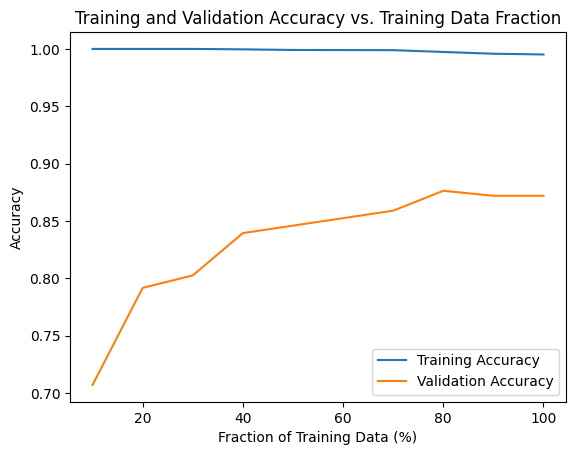

In [15]:

# Load the training and validation datasets
train_data = pd.read_csv("/content/train_text_seq.csv")
valid_data = pd.read_csv("/content/valid_text_seq.csv")

# Substrings to remove from the strings
remove_substrings_list = ['15436', '1596', '464', '614', '262', '422', '284']

# Function to remove the specified substrings from a sequence
def filter_substrings(sequence, substrings):
    for substring in substrings:
        sequence = sequence.replace(substring, '')  # Remove each specified substring
    return sequence

# Preprocessing function for the dataset
def clean_data(df):
    # Remove leading zeros
    df['cleaned_str'] = df['input_str'].apply(lambda x: x[3:])
    # Remove specific substrings
    df['modified_str'] = df['cleaned_str'].apply(lambda x: filter_substrings(x, remove_substrings_list))
    # Add a new column for the length of the modified string
    df['modified_length'] = df['modified_str'].apply(len)
    # Filter only strings with length 13 after modification
    df = df[df['modified_length'] == 13]
    return df

# Clean both the training and validation datasets
train_data = clean_data(train_data)
valid_data = clean_data(valid_data)


# Function to encode the strings as integer values
def string_to_int_encoding(df):
    # Create a set of all unique characters from the modified strings
    unique_chars = sorted(list(set("".join(df['modified_str'].values))))
    # Create a dictionary to map each character to a unique integer
    char_to_integer = {char: idx + 1 for idx, char in enumerate(unique_chars)}
    # Encode the modified string using the character to integer mapping
    df.loc[:, 'encoded_str'] = df['modified_str'].apply(lambda x: [char_to_integer[char] for char in x])  # Fix warning by using .loc
    return df, char_to_integer

# Apply the encoding function to both the training and validation data
train_data, char_to_integer_mapping = string_to_int_encoding(train_data)
valid_data, _ = string_to_int_encoding(valid_data)

# Prepare the data for XGBoost
# Flatten the list of integers for each encoded string to create feature columns
X_train_features = pd.DataFrame(train_data['encoded_str'].tolist())
y_train_labels = train_data['label'].values

X_valid_features = pd.DataFrame(valid_data['encoded_str'].tolist())
y_valid_labels = valid_data['label'].values

# Define the fractions of the training dataset to be used, ranging from 10% to 100%
data_fractions = np.linspace(0.1, 1.0, 10)

# Lists to store training and validation accuracies
training_accuracies = []
validation_accuracies = []

# Loop over different fractions of the training dataset
for fraction in data_fractions:
    # Select a subset of the training data
    subset_size = int(fraction * train_data.shape[0])
    X_train_subset = X_train_features[:subset_size]
    y_train_subset = y_train_labels[:subset_size]

    # Initialize the XGBoost classifier model (removed use_label_encoder)
    xgb_model = xgb.XGBClassifier(eval_metric='logloss')

    # Fit the model with the training subset
    xgb_model.fit(X_train_subset, y_train_subset)

    # Make predictions on the training data subset
    train_predictions = xgb_model.predict(X_train_subset)

    # Evaluate the model's performance using accuracy on training data
    train_accuracy = accuracy_score(y_train_subset, train_predictions)

    # Make predictions on the validation dataset
    valid_predictions = xgb_model.predict(X_valid_features)

    # Evaluate the model's performance using accuracy on validation data
    valid_accuracy = accuracy_score(y_valid_labels, valid_predictions)

    # Store the results
    training_accuracies.append(train_accuracy)
    validation_accuracies.append(valid_accuracy)

    # Print the accuracies
    print(f"Training with {fraction * 100:.1f}% of data - "
          f"Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Accuracy: {valid_accuracy:.4f}")

# You can plot the training and validation accuracies to see the trend
import matplotlib.pyplot as plt

plt.plot(data_fractions * 100, training_accuracies, label='Training Accuracy')
plt.plot(data_fractions * 100, validation_accuracies, label='Validation Accuracy')
plt.xlabel('Fraction of Training Data (%)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Training Data Fraction')
plt.legend()
plt.show()


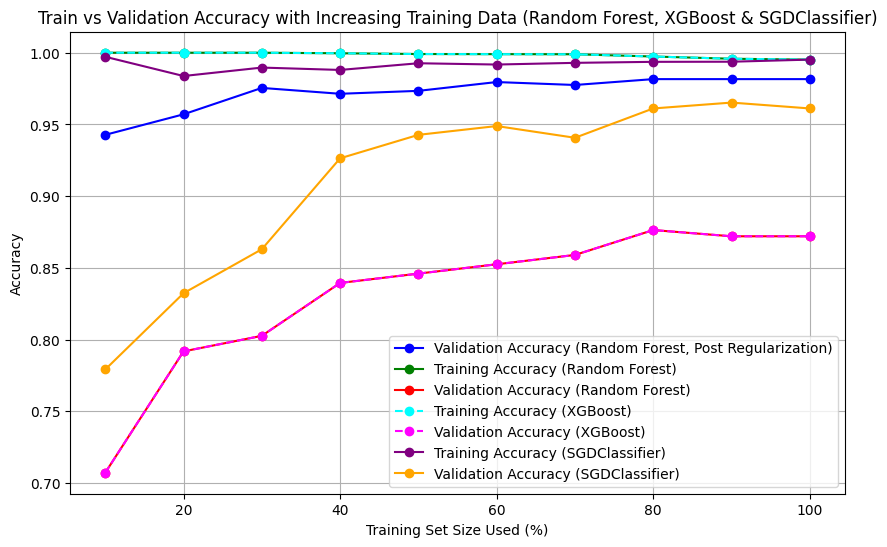

In [16]:
import matplotlib.pyplot as plt

# Combined plot for Random Forest, XGBoost, and SGDClassifier accuracies
plt.figure(figsize=(10, 6))

# Plot the Validation Accuracy vs. Training Set Size (Random Forest with Regularization)
plt.plot([int(f * 100) for f in data_fractions2], model_accuracies, label='Validation Accuracy (Random Forest, Post Regularization)', marker='o', color='blue')

# Plot the Training and Validation Accuracies for Random Forest (pre regularization)
plt.plot(data_fractions * 100, training_accuracies, label='Training Accuracy (Random Forest)', marker='o', color='green')
plt.plot(data_fractions * 100, validation_accuracies, label='Validation Accuracy (Random Forest)', marker='o', color='red')

# Plot the Training and Validation Accuracies for XGBoost
plt.plot(data_fractions * 100, training_accuracies, label='Training Accuracy (XGBoost)', marker='o', linestyle='--', color='cyan')
plt.plot(data_fractions * 100, validation_accuracies, label='Validation Accuracy (XGBoost)', marker='o', linestyle='--', color='magenta')

# Plot the Training and Validation Accuracies for SGDClassifier
plt.plot(fractions * 100, train_accuracies, label='Training Accuracy (SGDClassifier)', marker='o', color='purple')
plt.plot(fractions * 100, valid_accuracies, label='Validation Accuracy (SGDClassifier)', marker='o', color='orange')

# Add labels, title, legend, and grid
plt.title('Train vs Validation Accuracy with Increasing Training Data (Random Forest, XGBoost & SGDClassifier)')
plt.xlabel('Training Set Size Used (%)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
